# GDP analysis for Tunisia

## Imports 

In [1]:
import os
import pandas as pd
os.chdir('..')
print(os.getcwd())
from src.regressions import *
from src.helpers import *
from src.statistical_analysis import *
from src.evaluation_metrics import *
from src.feature_engineering import *
import matplotlib.pyplot as plt 
import seaborn as sns 

/home/nizar/Desktop/econometrics/GDP


## Loading and visualizing the dataset 

We start here by loading the dataset 

In [2]:
# We load the dataset in a pandas dataframe
PATH = os.path.join("data", "Tunisia2.csv")
dataset = pd.read_csv(PATH)

In [3]:
# We visualize the dataset
dataset

,YEAR,CGPD RELATIVE TO THE UNITED STATES (unit US=100),CONSUMPTION SHARE OF CGPD (unit %),CONSUMPTION SHARE OF RGDPL (unit %),CURRENT SAVINGS (unit %),EXCHANGE RATE (unit US=1),GOVERNMENT SHARE OF CGDP (unit %),GOVERNMENT SHARE OF RGDPL (unit %),INVESTMENT SHARE OF CGDP (unit %),INVESTMENT SHARE OF RGDPL (unit %),OPENNESS IN CONSTANT PRICES (unit %),OPENNESS IN CURRENT PRICES (unit %),POPULATION (unit 000S),PRICE LEVEL OF CONSUMPTION (unit PPP/XRATE),PRICE LEVEL OF GOVERNMENT (unit PPP/XRATE),PRICE LEVEL OF GROSS DOMESTIC PRODUCT (unit US=100),PRICE LEVEL OF INVESTMENT (unit PPP/XRATE),RATIO OF GNP TO GDP (CURRENT PRICES) (unit %),REAL GROSS DOMESTIC PRODUCT PER CAPITA (CURRENT PRICES) (unit $ CURRENT)
0,1950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1953,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1954,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1955,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1956,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1957,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1958,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The point here is to be able to predict the GDP for last few years given the some features.

Text(0.5, 1.0, "The evolution of the Tunisian GDP from the 60's to the 00's")

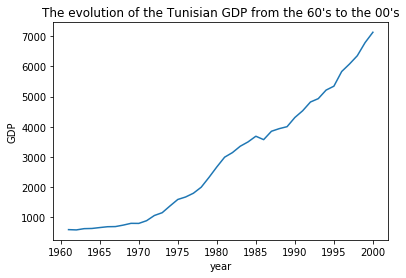

In [4]:
# We plot the GDP in function of the year 
plt.plot(dataset["YEAR"], dataset["REAL GROSS DOMESTIC PRODUCT PER CAPITA (CURRENT PRICES) (unit $ CURRENT)"])
plt.xlabel("year")
plt.ylabel("GDP")
plt.title("The evolution of the Tunisian GDP from the 60's to the 00's")

In [5]:
# We split the dataset into X matrix for containing all the predictors and y vector containing all the labels.
X, y = X_y_from_dataset(dataset)

# We print the shape of our data
print("We have", X.shape[0], "data points and", X.shape[1], "predictors")

We have 40 data points and 18 predictors


We start first by inspecting if the dataset has multicolinearity:

YEAR is highly correlated with:  CONSUMPTION SHARE OF CGPD (unit %), CURRENT SAVINGS (unit %), EXCHANGE RATE (unit US=1), INVESTMENT SHARE OF CGDP (unit %), INVESTMENT SHARE OF RGDPL (unit %), OPENNESS IN CURRENT PRICES (unit %), POPULATION (unit 000S) 

CGPD RELATIVE TO THE UNITED STATES (unit US=100) is highly correlated with:  CONSUMPTION SHARE OF RGDPL (unit %) 

CONSUMPTION SHARE OF CGPD (unit %) is highly correlated with:  YEAR, CURRENT SAVINGS (unit %), INVESTMENT SHARE OF CGDP (unit %), INVESTMENT SHARE OF RGDPL (unit %), OPENNESS IN CURRENT PRICES (unit %), POPULATION (unit 000S), PRICE LEVEL OF INVESTMENT (unit PPP/XRATE) 

CONSUMPTION SHARE OF RGDPL (unit %) is highly correlated with:  CGPD RELATIVE TO THE UNITED STATES (unit US=100) 

CURRENT SAVINGS (unit %) is highly correlated with:  YEAR, CONSUMPTION SHARE OF CGPD (unit %), INVESTMENT SHARE OF CGDP (unit %), INVESTMENT SHARE OF RGDPL (unit %), OPENNESS IN CURRENT PRICES (unit %), POPULATION (unit 000S), PRICE LEVEL OF I

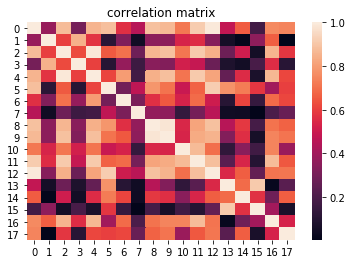

In [6]:
# We verify if we have a high correlation between certain predictors
correlation_matrix = np.abs(np.corrcoef(X, rowvar=False))
sns.heatmap(correlation_matrix)
plt.title("correlation matrix")
mask = correlation_matrix > 0.8
np.fill_diagonal(mask, False)
for i, m in enumerate(mask): 
    if (sum(m) != 0):
        print(dataset.columns[i], "is highly correlated with: ", ", ".join(dataset.columns[np.append(m, False)]), "\n")

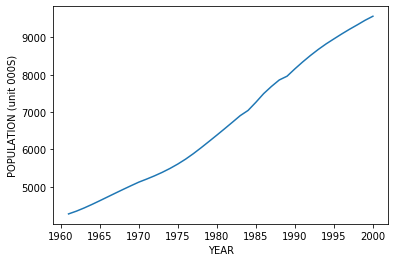

In [7]:
# We plot for example the almost linear relationship raltion between year and population 
sns.lineplot(x="YEAR", y="POPULATION (unit 000S)", data=dataset)

In [8]:
print("The condition number is", condition_number(X))

The condition number is 721299.9786209331


In [9]:
VIF_X = VIF(X)
print("The VIF is:", VIF_X, "\n The column with the highest VIF is", dataset.columns[np.argmax(VIF_X)])

The VIF is: [1.11645535e+03 1.00383625e+01 1.85640902e+05 1.04041459e+02
 2.61782827e+05 1.09828808e+02 1.19242677e+04 5.62882948e+01
 9.63289494e+02 1.01722758e+03 1.84383514e+01 7.79283378e+01
 1.11149562e+03 3.97871957e+02 3.30620479e+01 7.80897523e+02
 2.36946099e+02 1.14280386e+01] 
 The column with the highest VIF is CURRENT SAVINGS (unit %)


The condition number, VIF and correlation matrix all tend to indicate that our data is kind off ill conditionned. We have to perform at least either some model selection, or filter out some predictors.

## The models

We first naively apply the two models and see what we get on the test set.

### Least Squares

In [10]:
# We split the dataset as instructed: the first 80% as train and the next 20% as test.
X_train, X_test, y_train, y_test = train_test_split(X, y)

0

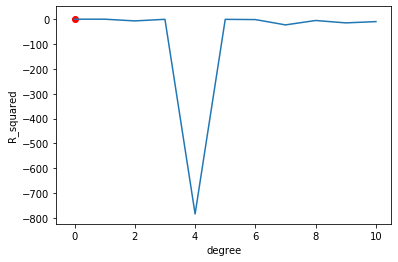

In [11]:
# Degree of zero means we leave the data set the way it is degree of 1 means we simply add a bias degree > 1 
# We compute the polynomial expansion associated with that degree.
d = degree_cross_val(X_train, y_train, 10)
d

In [12]:
# We split the dataset as instructed: the first 80% as train and the next 20% as test.
X_ls = build_poly(X, d)
X_train_ls, X_test_ls, y_train_ls, y_test_ls = train_test_split(X_ls, y)

In [13]:
# We train with the least squares estimator
w = least_squares(X_train_ls, y_train_ls)
result_for_X = predict(X_ls,w)

In [14]:
print("The R^2 for the test: ", R_squared(y_test, predict(X_test_ls,w)),
      "\nThe R^2 for the test: ", R_squared(y_train, predict(X_train_ls,w)), 
      "\nThe R^2 for the whole data set is:", R_squared(y, result_for_X))

The R^2 for the test:  0.2570474394541151 
The R^2 for the test:  0.9993445104667079 
The R^2 for the whole data set is: 0.9800708465850282


In [15]:
print("The adjusted R^2 for the whole data set:", adjusted_R_squared(y, result_for_X, X_ls.shape[1]))

The adjusted R^2 for the whole data set: 0.9629887150864809


The model does very well on the training set, however has a lot of trouble generalizing to the test set.   
Let us now visualize how confident we are in our predictions: 

In [16]:
# We compute the CI for the coefficients
X_for_var, w_for_var = (X_ls[:, 1:], w[1:]) if d > 0 else (X, w) 
var = variance_least_squares_weights(y, result_for_X, X_for_var)
lower_CI, upper_CI = confidence_interval(X_for_var.shape, w_for_var, var)

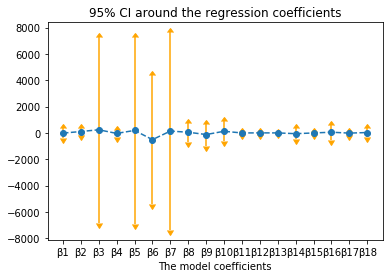

In [17]:
# We plot the coefficients with their CI intervals
plt.errorbar(np.arange(X_for_var.shape[1]), w_for_var, yerr=np.vstack([np.squeeze(w_for_var-lower_CI), np.squeeze(upper_CI-w_for_var)]), fmt="--o", ecolor='orange', lolims=True, uplims=True)
plt.xticks(np.arange(X_for_var.shape[1]), ["β"+str(i+1) for i in np.arange(X_for_var.shape[1])])
plt.title("95% CI around the regression coefficients")
plt.xlabel("The model coefficients")
plt.show()

In [18]:
# Here we compute the CI for the predictions
var_ = variance_least_squares_line(y, result_for_X, X_for_var)
lower_CI_line, upper_CI_line = confidence_interval(X_for_var.shape, result_for_X, var_)

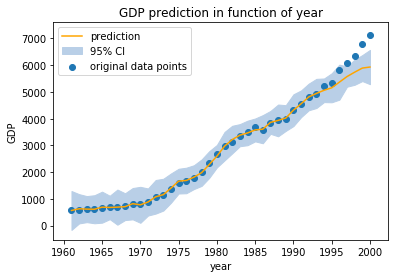

In [19]:
# Here we plot the CI for the predictions 
plt.gca().fill_between(X_for_var[:, 0], np.squeeze(lower_CI_line), np.squeeze(upper_CI_line), label="95% CI", color="#b9cfe7", edgecolor="")
plt.scatter(X_for_var[:, 0], y, label="original data points")
plt.plot(X_for_var[:, 0], predict(X_ls, w), color="orange", label="prediction")
plt.xlabel("year")
plt.ylabel("GDP")
plt.title("GDP prediction in function of year")
plt.legend()

The model accurately approximates the GDP for the first 80% data points (the training set) but starts diverging away in the last 20% data points (the test set).

### Ridge Regression

The least squares is just a special case of the ridge regression where $\lambda = 0$ for the penalty term.   
Let us now apply the ridge regression (which is solvable analytically given that the l2 norm is differentiable) and see if our performance improves.

In [20]:
lambda_, d_ridge = cross_val_ridge(X_train, y_train, plot=False)
X_expanded = build_poly(X, d_ridge)
X_train_expanded, X_test_expanded, y_train_expanded, y_test_expanded = train_test_split(X_expanded, y)
print("The optimal hyper-parameters for the polynomial expansion and l2 regularization term are respectively:", lambda_, d_ridge)

The optimal hyper-parameters for the polynomial expansion and l2 regularization term are respectively: 0.37373737373737376 1


In [21]:
# We train the ridge regression
w_r = ridge_regression(X_train_expanded, y_train_expanded, lambda_)
result_for_X_ridge = predict(X_expanded,w_r)

In [22]:
print("The R^2 for the test: ", R_squared(y_test, predict(X_test_expanded,w_r)),
      "\nThe R^2 for the test: ", R_squared(y_train, predict(X_train_expanded, w_r)), 
      "\nThe R^2 for the whole data set is: ", R_squared(y, result_for_X_ridge))

The R^2 for the test:  0.36887547307399804 
The R^2 for the test:  0.9992259879183839 
The R^2 for the whole data set is:  0.9829846316237163


In [23]:
print("The adjusted R^2 for the whole data set:", adjusted_R_squared(y, result_for_X_ridge, X_train_expanded.shape[1]))

The adjusted R^2 for the whole data set: 0.9668200316662467


As expected, thanks to the penalty term the ridge regression achieves lower training accuracy (less overfitting) for a higher test accuracy (Bias - variance trade off).  
Let us now visualize our predictions: 

In [24]:
# We compute the CI for the coefficients
X_for_var_ridge, w_for_var_ridge = (X_expanded[:, 1:], w_r[1:]) if d_ridge > 0 else (X, w_r) 
var_r = variance_least_squares_weights(y, result_for_X_ridge, X_for_var_ridge)
lower_CI_r, upper_CI_r = confidence_interval(X_for_var_ridge.shape, w_for_var_ridge, var_r)

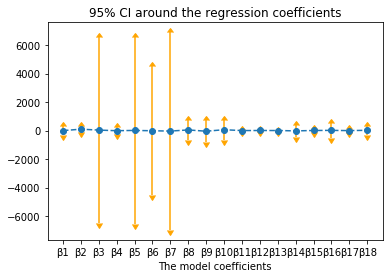

In [25]:
# We plot the coefficients with their CI intervals
plt.errorbar(np.arange(X_for_var_ridge.shape[1]), w_for_var_ridge, yerr=np.vstack([np.squeeze(w_for_var_ridge-lower_CI_r), np.squeeze(upper_CI_r-w_for_var_ridge)]), fmt="--o", ecolor='orange', lolims=True, uplims=True)
plt.xticks(np.arange(X_for_var_ridge.shape[1]), ["β"+str(i+1) for i in np.arange(X_for_var_ridge.shape[1])])
plt.title("95% CI around the regression coefficients")
plt.xlabel("The model coefficients")
plt.show()

In [26]:
# Here we compute the CI for the predictions
var_ridge = variance_least_squares_line(y, result_for_X_ridge, X_for_var_ridge)
lower_CI_line_r, upper_CI_line_r = confidence_interval(X_for_var_ridge.shape, result_for_X_ridge, var_ridge)

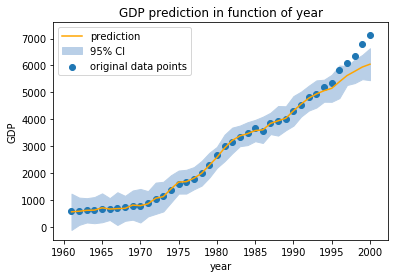

In [27]:
# Here we plot the CI for the predictions 
plt.gca().fill_between(X_for_var_ridge[:, 0], np.squeeze(lower_CI_line_r), np.squeeze(upper_CI_line_r), label="95% CI", color="#b9cfe7", edgecolor="")
plt.scatter(X_for_var_ridge[:, 0], y, label="original data points")
plt.plot(X_for_var_ridge[:, 0], predict(X_expanded, w_r), color="orange", label="prediction")
plt.xlabel("year")
plt.ylabel("GDP")
plt.title("GDP prediction in function of year")
plt.legend()

The ridge regression thanks to the penalty term lead to smaller coefficients, thus tighter confidence intervals. 

## Best subset selection, General to simple, Simple to general 

As we have previously seen, our data matrix is ill-conditionned and naively applying both models with feature expansion doesn't give the best results.   
So now we try three methods that are going to allow us to have a better conditionned data so we can perform our regressions on.

### Best subset selection 

In [29]:
scores, subsets = best_subset(X_train, y_train)

In [30]:
i = np.argmax(scores)
sub = subsets[i]
variables = "\n".join(dataset.columns[list(sub)])
print("Best performance on the test: ", scores[i], "the subset is: ", sub, "\nThis corresponds to the following variables:\n" + variables) 

Best performance on the test:  0.9985080358194323 the subset is:  (0, 1, 4, 9, 10, 12, 16) 
This corresponds to the following variables:
YEAR
CGPD RELATIVE TO THE UNITED STATES (unit US=100)
CURRENT SAVINGS (unit %)
INVESTMENT SHARE OF RGDPL (unit %)
OPENNESS IN CONSTANT PRICES (unit %)
POPULATION (unit 000S)
PRICE LEVEL OF INVESTMENT (unit PPP/XRATE)


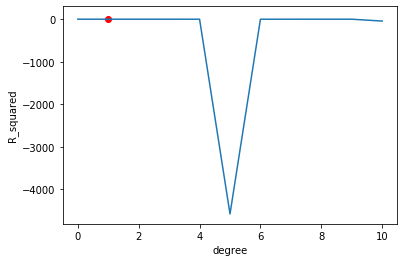

In [31]:
d_subset = degree_cross_val(X_train[:, sub], y_train, 10)
X_subset = build_poly(X[:, sub], d_subset)
X_train_subset, X_test_subset, y_train_subset, y_test_subset = train_test_split(X_subset, y)
w_ss = least_squares(X_train_subset, y_train_subset)
result_for_X_ss = predict(X_subset, w_ss)

In [32]:
print("the R^2 for the test: ", R_squared(y_test, predict(X_test_subset,w_ss)),
      "\nThe R^2 for the train:", R_squared(y_train, predict(X_train_subset,w_ss)),
      "\nThe R^2 of the whole data set is:", R_squared(y, result_for_X_ss))

the R^2 for the test:  0.2903146195917711 
The R^2 for the train: 0.9987768019497509 
The R^2 of the whole data set is: 0.9807270156968646


In [33]:
print("the adjusted R^2 for the whole data set:", adjusted_R_squared(y, result_for_X_ss, X.shape[1]))

the adjusted R^2 for the whole data set: 0.9642073148656057


In [ ]:
lambda_ss, d_subset_r = cross_val_ridge(X_train[:, sub], y_train, plot=False)
print("The optimal hyper-parameters for the polynomial expansion and l2 regularization term are respectively:", lambda_ss, d_subset_r)
X_subset_r = build_poly(X[:, sub], d_subset_r)
X_train_subset_r, X_test_subset_r, y_train_subset_r, y_test_subset_r = train_test_split(X_subset_r, y)
w_ss_r = ridge_regression(X_train_subset_r, y_train_subset_r, lambda_ss)
result_for_X_ss_r = predict(X_subset_r, w_ss_r)

In [ ]:
print("the R^2 for the test: ", R_squared(y_test_subset_r, predict(X_test_subset_r,w_ss_r)),
      "\nThe R^2 for the train:", R_squared(y_train_subset_r, predict(X_train_subset_r,w_ss_r)),
      "\nThe R^2 of the whole data set is:", R_squared(y, result_for_X_ss))